## DEMAND FORCASTING PROJECT

In [23]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Exploratory Data Analysis 

We download the customers dataset

In [2]:
data1=pd.read_csv("olist_customers_dataset.csv")
data1=data1.dropna()
display(data1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [3]:
# Number of clients per State
state_counts = data1["customer_state"].value_counts().reset_index()

# Interactive bar graph
fig = px.bar(state_counts, x="customer_state", y="count", labels={"customer_state": "State", "count": "Numbre of clients"})
fig.update_layout(title="Client distribution per state")
fig.show()

In [4]:
# Number of clients per city
city_counts = data1["customer_city"].value_counts().reset_index()

# We select the top 10 cities with the most clients
top_10_cities = city_counts.head(10)

# Interactive pie chart for top 10 cities
fig = px.pie(top_10_cities, names="customer_city", values="count", title="Clients distribution in the top 10 cities")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title="Clients distribution in the top 10 cities")
fig.show()

In [5]:
# Extracting the first two digits of the postal code
data1["zipcode_prefix"] = data1["customer_zip_code_prefix"].astype(str).str[:2]

# Counting the number of clients per postal code prefix
zipcode_counts = data1["zipcode_prefix"].value_counts().reset_index()

# Creating an interactive bar graph for postal code prefixes
fig = px.bar(zipcode_counts, x="zipcode_prefix", y="count", labels={"zipcode_prefix": "Postal codes", "count": "Number of clients"})

fig.show()

In [6]:
# Compute the number of clients per city
unique_customers = data1["customer_unique_id"].nunique()
repeated_customers = len(data1) - unique_customers

# Create a pie chart to visualize the distribution of unique and repeated customers
labels = ["Clients uniques", "Clients répétés"]
values = [unique_customers, repeated_customers]
fig = px.pie(names=labels, values=values, title="Distribution of unique and repeated clients")
fig.show()

Downloading of the orders dataset

In [7]:
orders = pd.read_csv("olist_orders_dataset.csv")

In [8]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [9]:
columns_tokeep=["order_status","order_purchase_timestamp"]

In [10]:
merged_data=orders[columns_tokeep]

merged_data = merged_data[merged_data['order_status'].str.contains('delivered')]
merged_data['order_status'] = merged_data['order_status'].replace("delivered", 1)

In [11]:
merged_data

,order_status,order_purchase_timestamp
0,1,2017-10-02 10:56:33
1,1,2018-07-24 20:41:37
2,1,2018-08-08 08:38:49
3,1,2017-11-18 19:28:06
4,1,2018-02-13 21:18:39
...,...,...
99436,1,2017-03-09 09:54:05
99437,1,2018-02-06 12:58:58
99438,1,2017-08-27 14:46:43
99439,1,2018-01-08 21:28:27


In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_status              96478 non-null  int64 
 1   order_purchase_timestamp  96478 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


In [13]:
#Datetime conversion
from datetime import datetime
merged_data["order_purchase_timestamp"] = pd.to_datetime(merged_data["order_purchase_timestamp"]).dt.date
merged_data["order_purchase_timestamp"] = pd.to_datetime(merged_data["order_purchase_timestamp"])

merged_data.info()
merged_data

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_status              96478 non-null  int64         
 1   order_purchase_timestamp  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.2 MB


,order_status,order_purchase_timestamp
0,1,2017-10-02
1,1,2018-07-24
2,1,2018-08-08
3,1,2017-11-18
4,1,2018-02-13
...,...,...
99436,1,2017-03-09
99437,1,2018-02-06
99438,1,2017-08-27
99439,1,2018-01-08


In [14]:
# time index

merged_data.sort_values(by='order_purchase_timestamp',inplace=True)
merged_data.set_index('order_purchase_timestamp',inplace=True)
display(merged_data)


,order_status
order_purchase_timestamp,
2016-09-15,1
2016-10-03,1
2016-10-03,1
2016-10-03,1
2016-10-03,1
...,...
2018-08-29,1
2018-08-29,1
2018-08-29,1


In [15]:
#Sales per day 

sales_per_day=merged_data.groupby('order_purchase_timestamp').size().reset_index(name='Sales')
display(sales_per_day)

,order_purchase_timestamp,Sales
0,2016-09-15,1
1,2016-10-03,7
2,2016-10-04,54
3,2016-10-05,35
4,2016-10-06,41
...,...,...
607,2018-08-25,69
608,2018-08-26,73
609,2018-08-27,66
610,2018-08-28,39


In [16]:
import plotly.express as px


fig = px.line(sales_per_day, x="order_purchase_timestamp", y="Sales" ,title='Sales per day')
fig.show()

We can see that there is many outliers

In [17]:
# Removal using the IQR (Interquartile Range)

Q1 = sales_per_day['Sales'].quantile(0.25)
Q3 = sales_per_day['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Only keep values within [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
filtered_sales = sales_per_day[(sales_per_day['Sales'] >= Q1 - 1.5 * IQR) & 
                              (sales_per_day['Sales'] <= Q3 + 1.5 * IQR)]

display(filtered_sales)

,order_purchase_timestamp,Sales
0,2016-09-15,1
1,2016-10-03,7
2,2016-10-04,54
3,2016-10-05,35
4,2016-10-06,41
...,...,...
607,2018-08-25,69
608,2018-08-26,73
609,2018-08-27,66
610,2018-08-28,39


In [18]:
# Removing values before 2017 and after 2018
filtered_sales = filtered_sales[(filtered_sales['order_purchase_timestamp'] >= '2017-01-01') &
                               (filtered_sales['order_purchase_timestamp'] <= '2018-12-31')]
display(filtered_sales)

,order_purchase_timestamp,Sales
10,2017-01-05,32
11,2017-01-06,4
12,2017-01-07,4
13,2017-01-08,4
14,2017-01-09,5
...,...,...
607,2018-08-25,69
608,2018-08-26,73
609,2018-08-27,66
610,2018-08-28,39


In [19]:
import plotly.express as px


fig = px.line(filtered_sales, x="order_purchase_timestamp", y="Sales" ,title='Sales per day')
fig.show()

### ACF and PACF

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) are two essential tools in time series analysis. They help to understand temporal dependencies within a dataset.

#### ACF (Autocorrelation Function)

The ACF measures the correlation between a sequence and itself at different time lags. In other words, it evaluates the similarity between observations as a function of the time lag between them.

**For a lag 'k', the ACF measures the correlation between the time series and itself shifted by 'k' periods.**

For example, **an ACF of 0.9 at lag 2 means the data is very similar to itself two periods ago**.

#### PACF (Partial Autocorrelation Function)

The PACF measures the correlation between observations at a certain lag, after removing the effects of shorter lags. It is the correlation between the time series and itself at lag 'k', after accounting for the correlations at lags 1 to 'k-1'.

For example, **a PACF of 0.5 at lag 3 means the data is moderately similar to itself three periods ago, after considering lags 1 and 2**.

#### Uses

ACF and PACF plots are commonly used to help select parameters for an ARIMA model in time series analysis. For example, **the ACF plot can be used to identify the MA (moving average) term** of the model, while the **PACF plot can help identify the AR (autoregressive) term**.


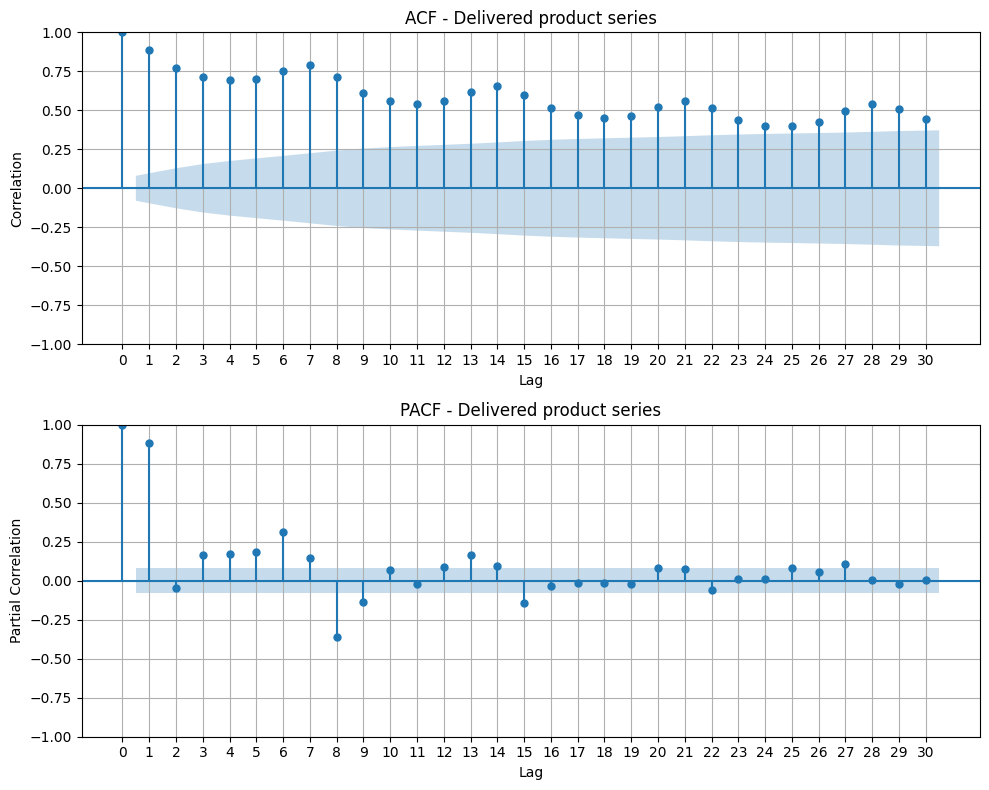

In [25]:
data=filtered_sales.set_index('order_purchase_timestamp')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the AutoCorrelation Function (ACF)
plot_acf(data, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Delivered product series')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')
ax1.grid(True)


ax1.set_xticks(np.arange(0, 31, 1))

# Plot the Partial AutoCorrelation Function (PACF)
plot_pacf(data, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Delivered product series')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Correlation')
ax2.grid(True)


ax2.set_xticks(np.arange(0, 31, 1))


plt.tight_layout()

plt.show()


The previous ACF shows that the series is not stationary because we observe a regular decay.

The lag were the PACF cut is 2.

p = 2 


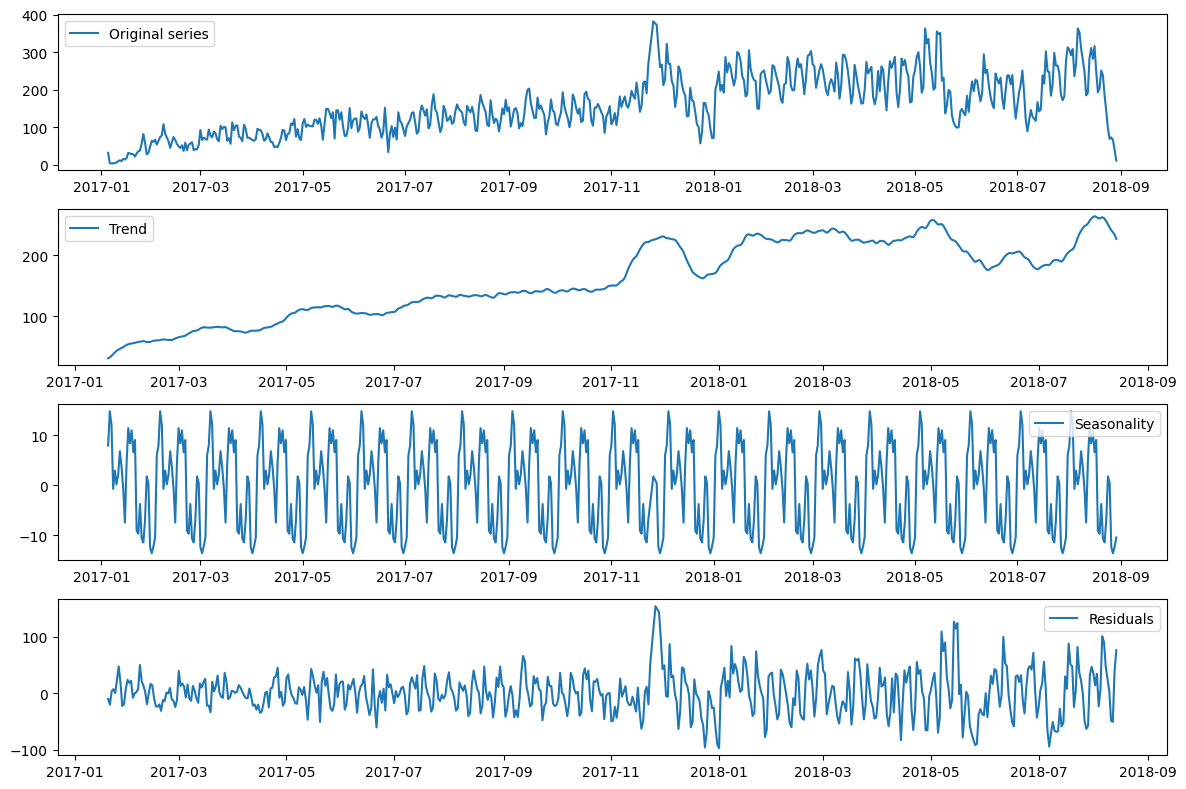

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Effectuer la décomposition saisonnière
decomposition = seasonal_decompose(data['Sales'], model='additive',period=30)

# Extraire les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Afficher les composantes de la décomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(data['Sales'], label='Original series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

- **Original series**: This is the observed sales series, as is.
- **Trend**: Shows the overall evolution of sales over the period (increase, decrease, or long-term stability).
- **Seasonality**: Highlights recurring patterns at regular intervals (for example, peaks each month or week).
- **Residuals**: These are the variations not explained by trend or seasonality (noise or exceptional events).



In [26]:
# Differencing to make the series stationary
differenced = filtered_sales['Sales'].diff().dropna()

fig = px.line(differenced, y="Sales" ,title='Differenced')
fig.update_layout(xaxis_title='Date', yaxis_title='Differenced Sales')
fig.show()

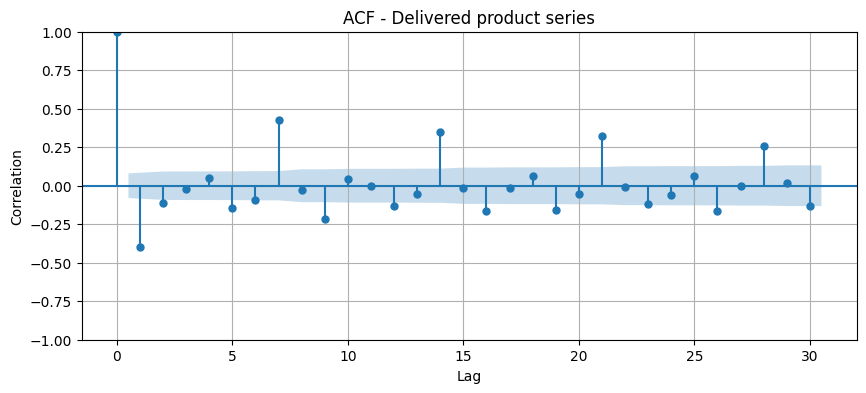

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(differenced, lags=30, zero=True, ax=ax)
ax.set_title('ACF - Delivered product series')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax.grid(True)
plt.show()


The previous ACF shows that the series is now stationary and the cut lag is the third one. 


q = 3, 
d = 1

ARIMA model from statsmodels

/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/engenouadje/Library/Python/3.9/lib/python/site-pac

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  599
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2945.255
Date:                Thu, 29 May 2025   AIC                           5902.510
Time:                        15:41:57   BIC                           5928.871
Sample:                             0   HQIC                          5912.773
                                - 599                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2783      0.121     -2.296      0.022      -0.516      -0.041
ar.L2         -0.2316      0.080     -2.886      0.004      -0.389      -0.074
ma.L1          0.1242      0.108      1.150      0.2

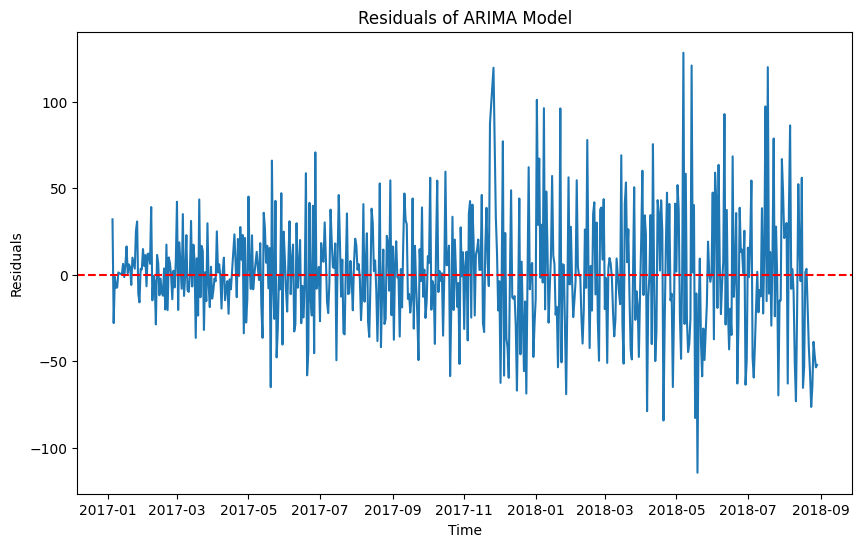

In [55]:
from statsmodels.tsa.arima.model import ARIMA
p=2
q=3
d=1
# Fit the ARIMA model
train_data = data

model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()
# # Print the model summary
print(model_fit.summary())
# Plot the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

<Figure size 1000x500 with 0 Axes>

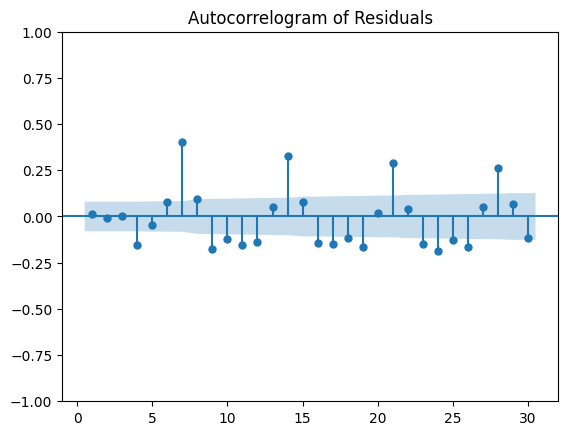

<Figure size 1000x500 with 0 Axes>

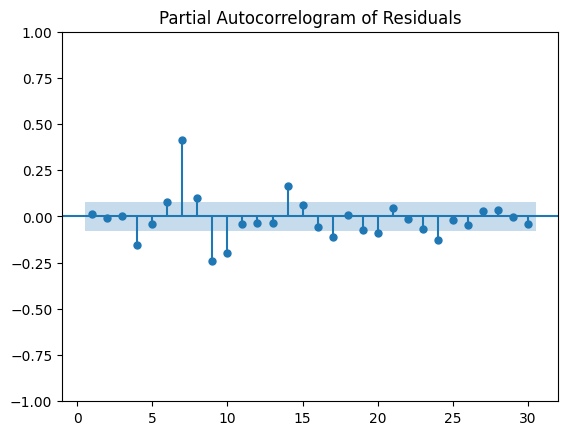

In [51]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30, zero=False)
plt.title("Autocorrelogram of Residuals")
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=30, zero=False)
plt.title("Partial Autocorrelogram of Residuals")
plt.show()


Trying auto_arima to see if I can get better results 

/var/folders/x3/q7_rm0gn54db09dyjz_5xgtr0000gn/T/ipykernel_1053/3708253402.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  579
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 629.918
Date:                Thu, 29 May 2025   AIC                          -1249.837
Time:                        16:23:30   BIC                          -1228.039
Sample:                             0   HQIC                         -1241.337
                                - 579                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1978      0.027     44.601      0.000       1.145       1.250
ar.L2         -0.8775      0.025    -35.525      0.000      -0.926      -0.829
ma.L1         -1.3617      0.035    -38.856      0.0

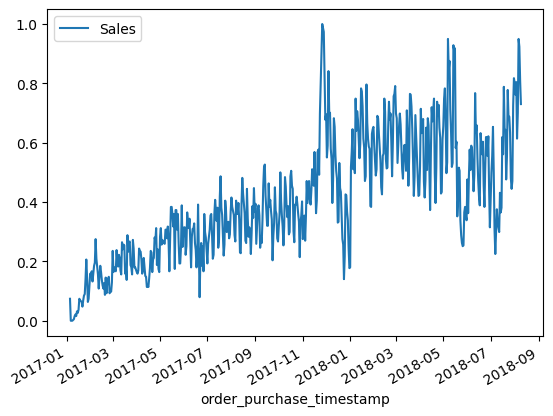

In [77]:
import pmdarima as pm

from sklearn.preprocessing import MinMaxScaler
# Séparer les données en ensemble d'entraînement et ensemble de sales_per_day

train_data = data[:-20]
scaler = MinMaxScaler()


train_data['Sales'] = scaler.fit_transform(train_data[['Sales']])  # Remarquez les doubles crochets autour de 'Sales'

# Maintenant, train_data contient toutes les colonnes du dataframe d'origine avec 'Sales' normalisé

train_data.plot()


# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)

print(model.summary())
#modif
# Faire des prévisions


/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/engenouadje/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



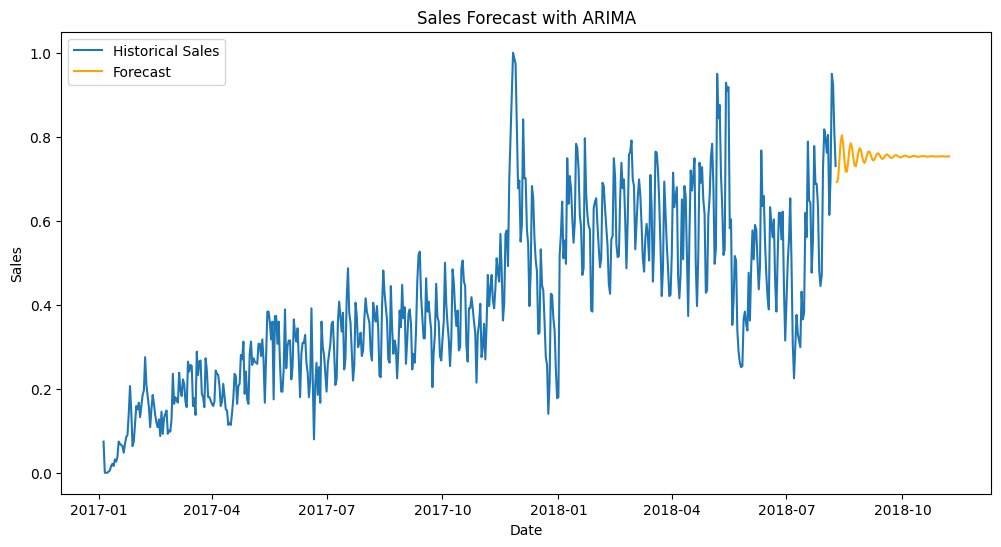

In [78]:
n_steps = 90  # Number of days to forecast
forecast, conf_int = model.predict(n_periods=n_steps, return_conf_int=True)
forecast_clipped = np.clip(forecast, 0, 1)
forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq='D')
forecast_df = pd.DataFrame(forecast_clipped, index=forecast_index, columns=['Forecast'])
forecast_df['Forecast'] = scaler.inverse_transform(forecast_df[['Forecast']])


# Inverse transform the normalization for the forecasts
forecast_clipped = np.clip(forecast, 0, 1)
forecast_df['Forecast'] = scaler.inverse_transform(forecast_clipped.values.reshape(-1, 1))
# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, scaler.inverse_transform(train_data[['Sales']]), label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Resume 

To conclude the dataset do not allow us to predict sales for a long enough period of time ( > 7 days ).

Beside that, this project explores the use of the ARIMA model for demand forecasting. We applied ARIMA to historical sales data, following a complete time series analysis workflow: data cleaning, visualization, stationarity checks, decomposition, and model fitting.

In addition to building the ARIMA model, we interpreted the key metrics provided in the `model.summary()` output:

- **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)**: Lower values indicate a better model fit with fewer parameters.
- **Coefficients**: Show the estimated impact of each AR, I, and MA term in the model.
- **Standard Errors and z-values**: Help assess the statistical significance of each coefficient.
- **Log-Likelihood**: Measures how well the model explains the observed data.
- **Residual Diagnostics**: Indicate if the model errors are random (white noise), which is desirable for a good fit.

By analyzing these metrics, we evaluated the quality of our ARIMA model and its suitability for forecasting future demand.
